## Perceptron and Data augmentation 
In this showcase we use the Perceptron classifier to classify two characters. In the next cells of this notebook, images having the characters are loaded and a couple of variations for them are created. Finally, we classify everything using sklearn's Perceptron implementation.

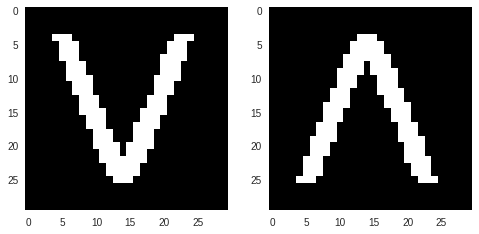

In [49]:
from skimage.io import imread
from matplotlib import pyplot as plt

# Read images having the two characters to be classified
V = imread("V.png", as_grey=True)
V_inv = imread("inv_V.png", as_grey=True)

# exhibits the two images loaded
rows = 1
columns = 2
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(rows, columns, 1)
plt.grid(False)
plt.imshow(V)
fig.add_subplot(rows, columns, 2)
plt.grid(False)
plt.imshow(V_inv)
plt.show()


---

Given the loaded images, we have a data augmentation step to create 16 variations of them. The `gen_data` function is responsible for generating any desired number of random variations all based in a single input image. Variations are created using pepper noise and image rotations.

In [ ]:
import random
from skimage.util import random_noise
from skimage import transform

# Function to generate image variations based on input parameters for image to use, quantity to generate,
# label to set for generated images, list of generated images and list of labels
def gen_data(base_image, quantity, label, data, target):
  
    # Generate 'quantity' number of images using random parameters
    for i in range(0, quantity):
        pepper_noise_seed = random.randint(10, 20)
        rotation_degrees = random.uniform(-25, 25)
        
        # First apply pepper effect to image, then rotate it and append to list of generated images
        noise_fig = random_noise(base_image, mode='pepper', seed=pepper_noise_seed, clip=True)
        rotate_fig = transform.rotate(noise_fig, rotation_degrees, resize=False, center=None, order=1, mode='constant', cval=1, clip=True, preserve_range=True)
        data.append(rotate_fig)
        target.append(label)
    
# Plot images in a grid having the specified number of rows and columns
def plot_images(array, rows, columns):
    fig = plt.figure(figsize=(8, 8))

    for i, j in enumerate(array):
        fig.add_subplot(rows, columns, i + 1)
        plt.grid(False)
        plt.imshow(j)
    plt.show()


---


Call generator and plotting funtions defined above to show example of generated images.

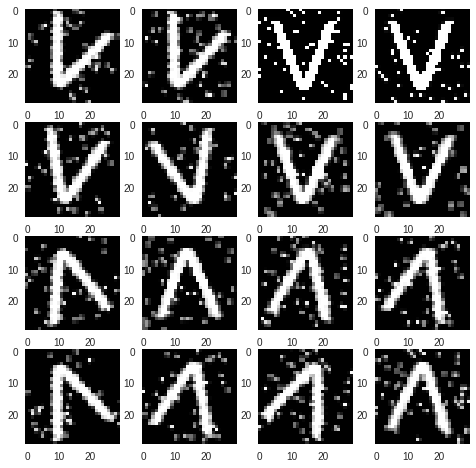

In [52]:
import numpy as np

X = []
y = []

# Call function to generate 16 images based on the 2 original images. 
# 0 and 1 are the labels for variations based on the first and the second original image, respectively
gen_data(V, 8 , 0, X, y)
gen_data(V_inv, 8, 1, X, y)
X = np.asarray(X)
y = np.asarray(y)

# Show generated images in a 4x4 grid
plot_images(X, 4, 4)


---

The augmented dataset with 16 images will be separated in a training set and a testing set having 12 and 4 images, respectively, using sklearn's function `train_test_split`. After that, a Perceptron classifier is trained and evaluated considering accuracy.

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

# Aplica o redimensionamento aos objetos do dataset para transformá-los em lista
x_reshape = np.reshape(x, (len(x), 900))

# Divide a lista nas porções de treino e de teste pedidas 
x_train, x_test, y_train, y_test = train_test_split(x_reshape, y, test_size=0.25, random_state=42)

# Instância o Perceptron com critério de parada 1e-3 e randomização do dataset em 0
classificador = Perceptron(tol=1e-3, random_state=0)

# Treina o classificador no conjunto de treino
classificador.fit(x_train, y_train) 

# Realiza a predição com o classificador treinado, sobre o conjunto de teste
y_pred_test = classificador.predict(x_test)

# Obtém a acurácia da predição no conjunto de teste
acc_test = accuracy_score(y_test, y_pred_test)

# Realiza uma predição no conjunto de treino
y_pred_train = classificador.predict(x_train)

# Obtém a acurácia da predição no conjunto de treino
acc_train = accuracy_score(y_train, y_pred_train)

# Exibe as acurácias calculadas acima
print('Acurácia conjunto de teste: %.2f' % acc_test)
print('Acurácia conjunto de treino: %.2f' % acc_train)

Acurácia conjunto de teste: 1.00
Acurácia conjunto de treino: 1.00


Após realizar todos os passos de redimensionamento da entrada, e de treinamento do classificador, chegou-se a uma previsão com acurácia igual a 1, ou 100% de acurácia, com o retorno 1 indicando a fração dos elementos corretamente classificados, o retorno máximo. O alto nível de acurácia se deve à simplicidade do dataset, que só possui duas classes, ou seja, pode ser considerado um dataset linearmente separável.



---

Devido à natureza da função threshold, podemos ter uma falsa sensação de quê nosso classificador classifica os exemplos com a mesma confiança. Porém, isso não é verdadeiro. No caso do perceptron utilizado, podemos ter uma medida da confiança do classificador para um dado exemplo calculando a distância relativa desse exemplo para o hiperplano separador. Essa medida pode ser obtida através da função `decision_function(X)`

- Utilize a função  `decision_function(X)` para calcular a distância dos exemplos query0.png ~ query4.png ao hiperplano separador do classificador treinado no item anterior e analise a relação entre distância x confiança x qualidade do símbolo na imagem.

In [54]:
# Carrega as imagens de exemplo
x_q = [imread("query0.png", as_grey=True), imread("query1.png", as_grey=True), 
       imread("query2.png", as_grey=True), imread("query4.png", as_grey=True)]

# Redimensiona as imagens de exemplo para que sejam usadas no Perceptron
x_q =  np.reshape(x_q, (len(x_q), 900))

# Exibe o retorno da função de decisão do classificador sobre as imagens de exemplo
print(classificador.decision_function(x_q))


[ 2.69933432 16.04689346 22.25859609  3.70514264]


De acordo com a definição da função decision_function do Perceptron implementado no scikit_learn, nos casos binários, com duas classes, temos que o valor de confiança positivo retornado para o sample de entrada afirma que ele seria corretamente classificado pelo modelo. Caso o valor retornado seja negativo, isso implica que o sample informado não seria corretamente classificado pelo modelo treinado.

O retorno da função é o score de confiança, definido como a distância, com sinal, entre o sample de exemplo e o hiperplano separador.

Observando a qualidade dos símbolos nas quatro imagens de exemplo, percebe-se que a primeira (query0) e a quarta (query4) imagem realmente possuem símbolos com qualidade bem baixa e bastante diferentes dos símbolos presentes no dataset de treinamento, e inclusive, no de teste. O que corrobora o baixo score de confiança retornado para estes exemplos. O símbolo presente na segunda figura (query1) mesmo tendo uma qualidade maior e uma semelhança também maior com os dados de treino, ainda assim é diferente, resultando em um score bom, porém ainda menor que o score da próxima imagem.

No caso da terceira imagem (query2) temos um símbolo de alta qualidade e que contém uma aparência similar aos símbolos do dataset de treinamento, podendo ser facilmente visualizado como um V invertido e classificado com alto score de confiança pelo Perceptron.

É possível então concluir que a qualidade do símbolo presente na imagem afeta diretamente na confiança da classificação e na distância em relação ao hiperplano separador. Quanto menor a qualidade ou quanto menor a semelhança entre o símbolo do sample e os símbolos do dataset de treinamento, menor será a confiança da predição e menor será a distância entre o exemplo e o hiperplano.